In [1]:
import os, sys, inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from options.test_options import TestOptions
from data.data_loader import CreateDataLoader
from models.models import create_model

from importlib import reload
from pbw_utils import zdataset, show, labwidget, paintwidget, renormalize, nethook, imgviz, pbar
from PIL import Image
import numpy as np
import torch

In [2]:
#load model
cmd = ('--name circle_mask_instance '
       '--netG modulated ' 
       '--input_nc 3 ' 
       '--label_nc 0 ' 
       '--dataroot /datasets/lsun_bedrooms/ ' 
       '--which_epoch 200 ' 
      ).split()

opt = TestOptions().parse(save=False, cmd=cmd)
model = create_model(opt)

------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
data_type: 32
dataroot: /datasets/lsun_bedrooms/
debug: False
display_winsize: 512
engine: None
export_onnx: None
feat_num: 3
fineSize: 512
fp16: False
frac_neg_one: False
frac_one: False
generated: False
gpu_ids: [0]
how_many: 50
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 0
linspace_off: False
linspace_on: False
loadSize: 1024
load_features: False
local_rank: 0
masked: False
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 9
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 4
n_local_enhancers: 1
n_stylechannels: 1
name: circle_mask_instance
nef: 16
netG: modulated
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: False
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: False
tf_log: False
use


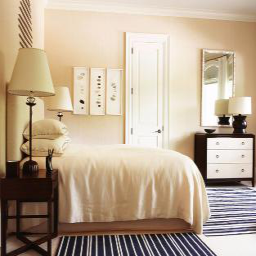

In [3]:
#load image
import torchvision.transforms as transforms
from data.base_dataset import __scale_width
transforms = transforms.Compose([transforms.Lambda(lambda img: __scale_width(img, opt.loadSize)), 
              transforms.ToTensor(),
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

img_path = 'datasets/lsun_bedrooms/test_A/0000128037967f0d4b7ba748a80d5b248d1203f8.webp'
#img_path = 'datasets/outofdomain5/test_A/IMG_2534.jpeg'
#img_path = 'datasets/bedrooms/test_A/lsun1.jpeg'
#img_path = 'datasets/outofdomain5/test_A/IMG_2563.jpeg'
#img_path = 'datasets/agata_light_all/test_A/place106_2_light_2.jpg'
#img_path = 'datasets/bedrooms/test_A/wa309_2.jpg'

dims = (256, 256)
image = Image.open(img_path).resize(dims, Image.BILINEAR)
show(image)
baseline = transforms(image.convert('RGB'))


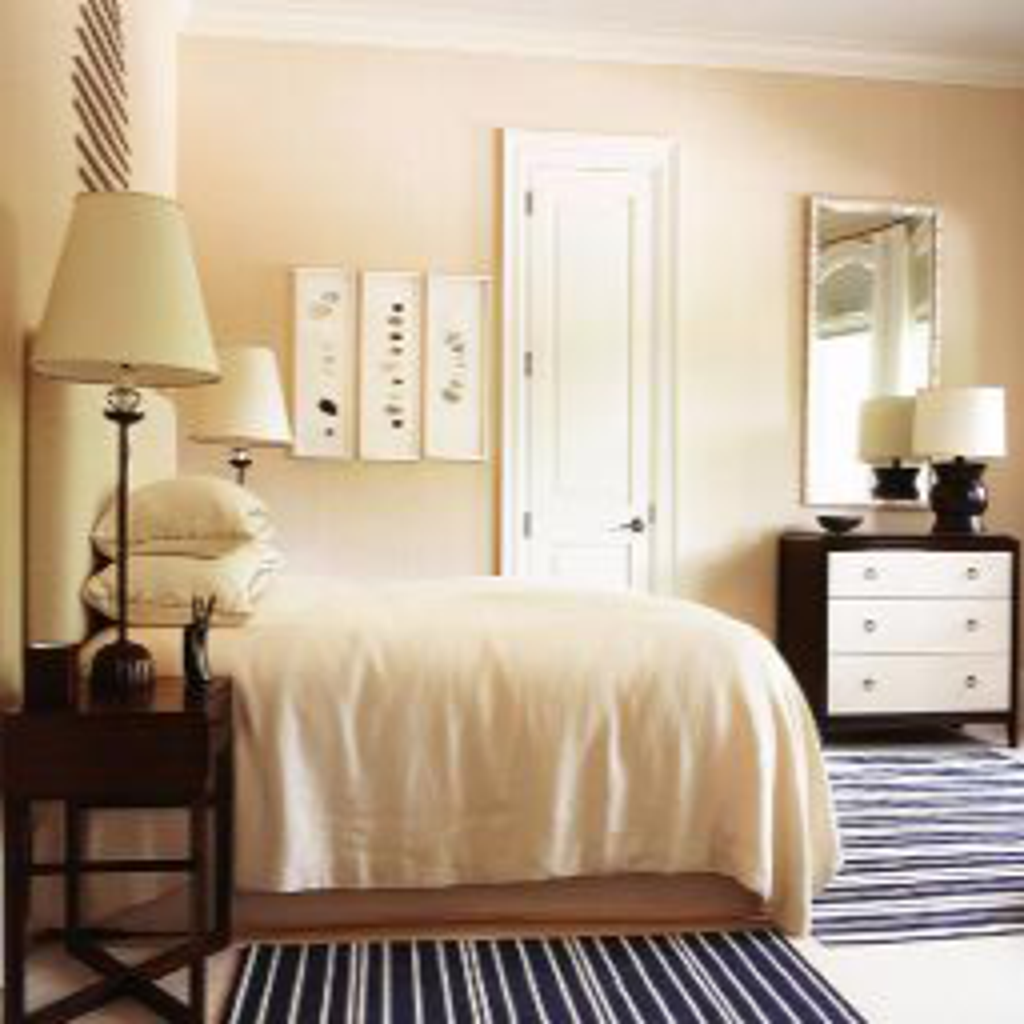

In [4]:
pw = paintwidget.PaintWidget(image=renormalize.as_url(baseline))
def do_reset():
    pw.mask = ''
reset_btn = labwidget.Button('reset').on('click', do_reset)
show([pw, reset_btn])

In [ ]:
#pw.mask = ''


In [5]:
#get feature map from mask
#mask = renormalize.from_url(pw.mask, target='pt', size=baseline.shape[1:])[0]
print(baseline.shape)
mask = renormalize.from_url(pw.mask, target='pt', size=baseline.shape[1:])[0]
print(mask.shape)
#print(torch.unique(mask))

torch.Size([3, 1024, 1024])
torch.Size([1024, 1024])



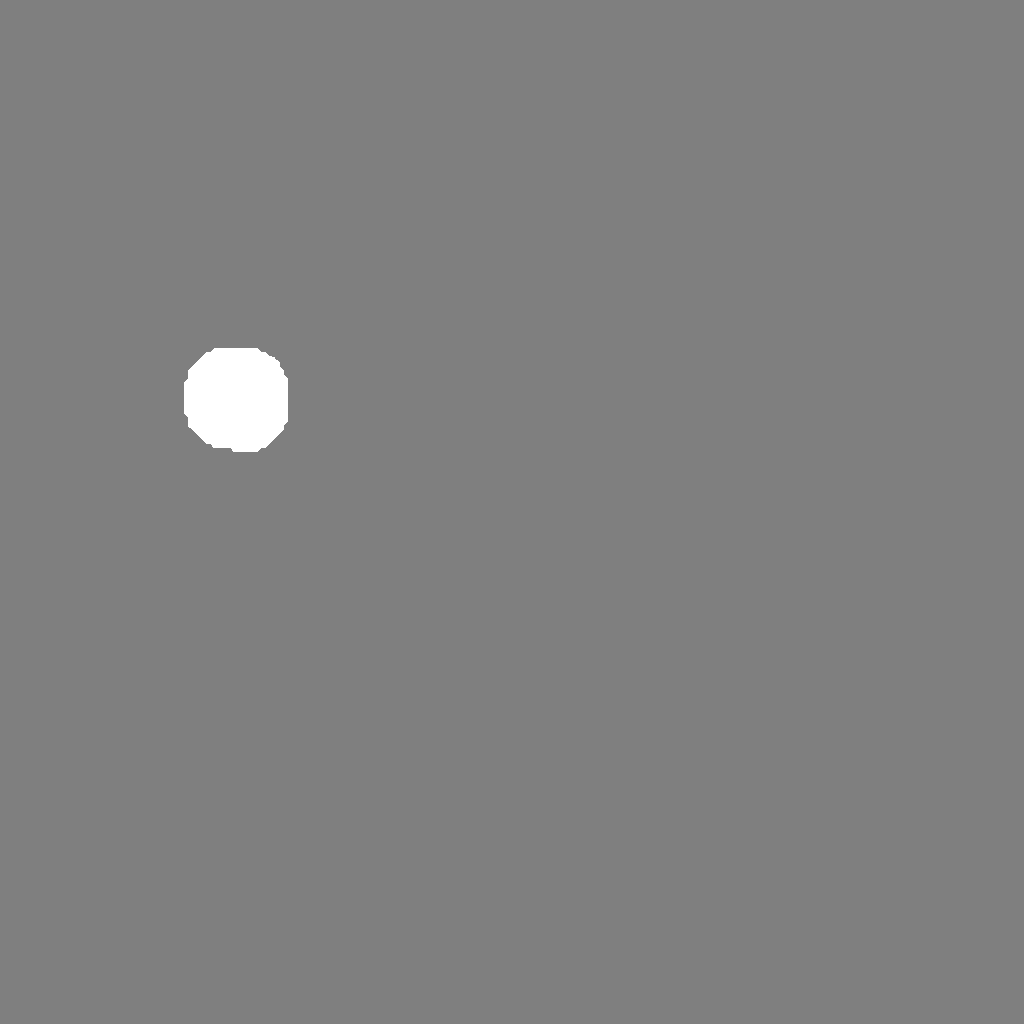

torch.Size([1024, 1024])


In [6]:
#mask_ = mask.reshape((mask.shape[1], mask.shape[0]))
mask[mask>0.5] =1
mask[mask<=0.5] =0
mask = mask
show(renormalize.as_image(mask[None]))
print(mask.shape)

torch.Size([1, 1, 1024, 1024])



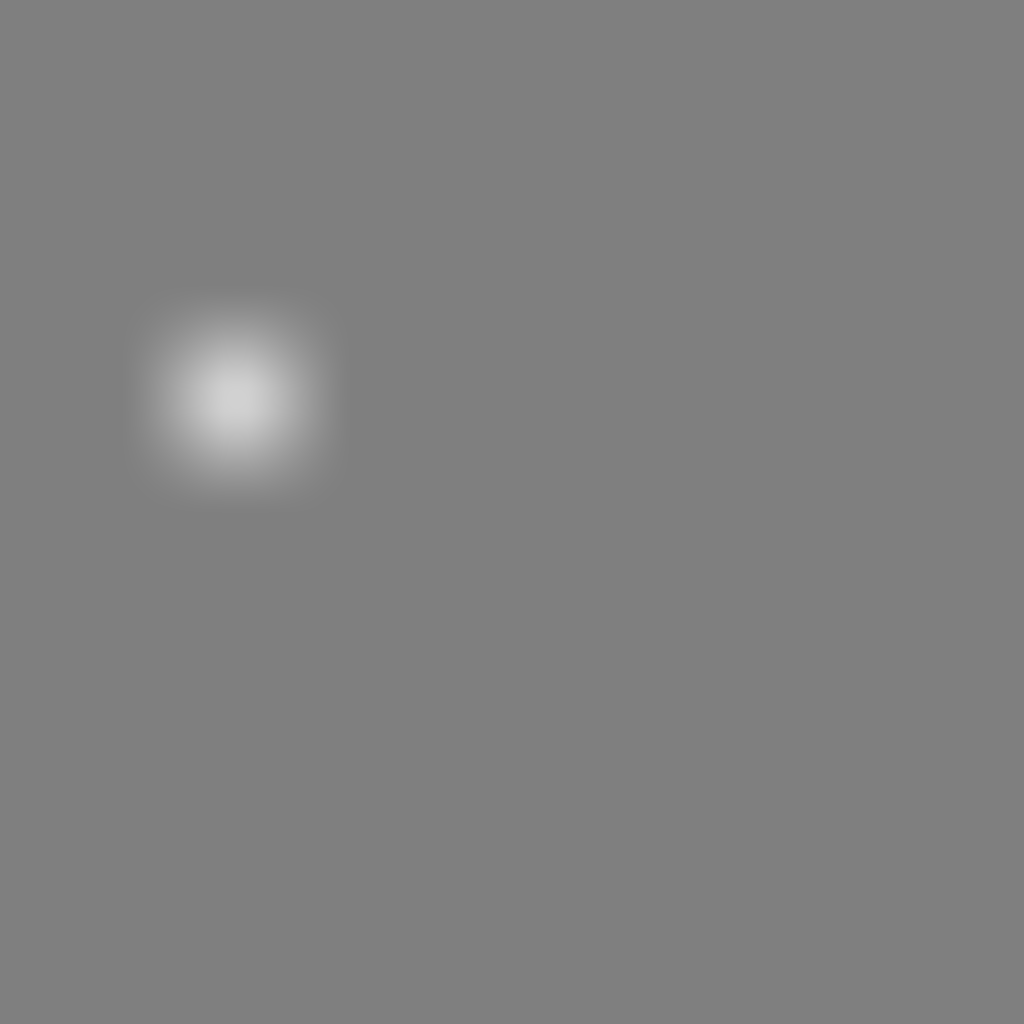

In [7]:
from pbw_utils import smoothing
sigma = float(1024) / 16.0
kernel_size = (int(sigma) * 2 - 1)
blur = smoothing.GaussianSmoothing(1, kernel_size, sigma=sigma)
mask_ = blur(mask[None, None])
print(mask_.shape)
show(renormalize.as_image(mask_[0].repeat(3, 1, 1)))


torch.Size([1, 1024, 1024])



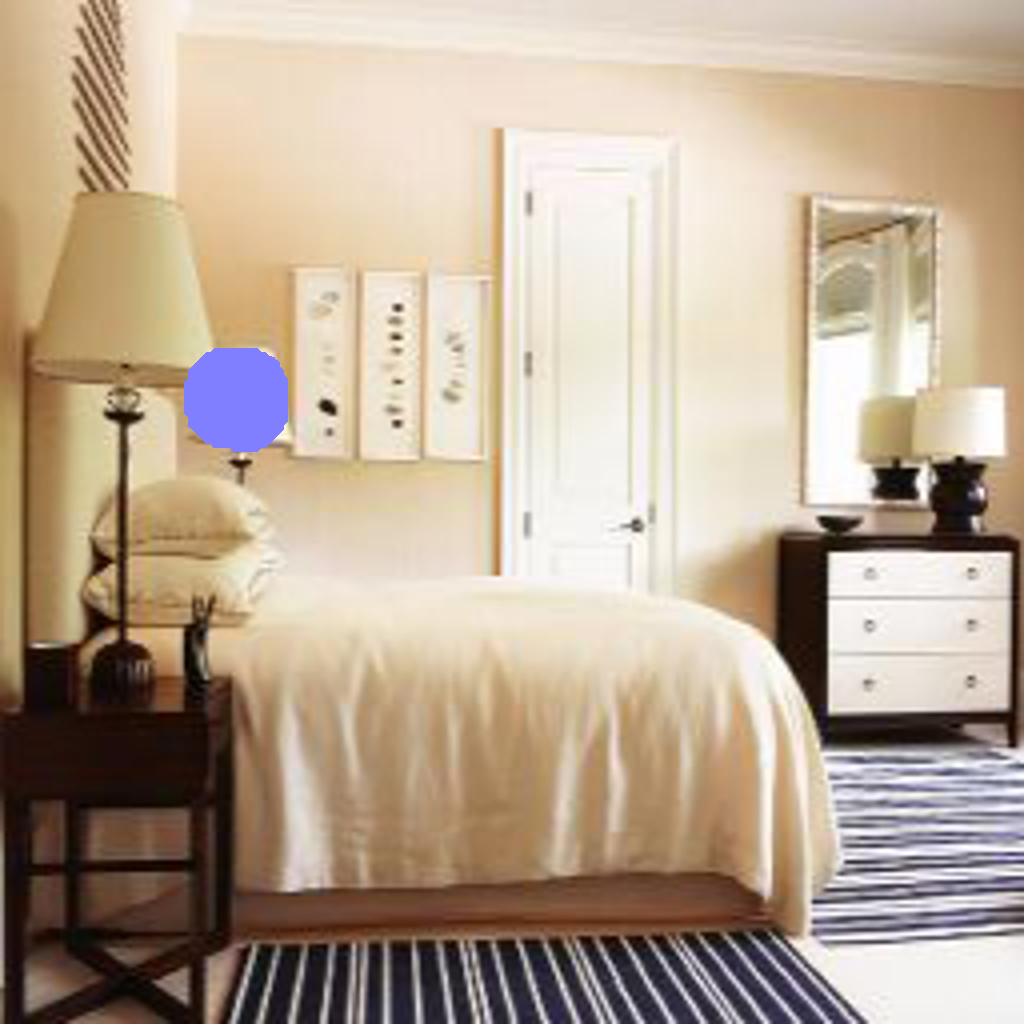

In [8]:
mask_copy = torch.clone(mask)
#mask_copy[mask_copy>0] = torch.max(baseline)
mask_img = mask_copy[None]#.repeat(3, 1, 1)
print(mask_img.shape)
#temp = mask_img.repeat(3,1,1)[1,:,:] = 0
temp = torch.clone(mask_copy)
temp[temp>0] = torch.max(baseline)
temp3 = torch.zeros(temp.shape)
temp2 = [temp3, temp3, temp]
temp2 = torch.stack(temp2)
show(renormalize.as_image(baseline*(1-mask_img)+ temp2))

In [ ]:
#widget for controlling lamps and windows

reload(labwidget)
lamp = labwidget.Range()
im = labwidget.Image()
lc = labwidget.ColorPicker('#ffffff', desc='lamp light color: ')

# #num.value = image_number
# lay.value = 'layer8'
# uni.value = 397

#show([['lamp intensity', lamp, '', 'window intensity', window, im]])
show([['lamp intensity', lamp, lc, im]])
#show([['lamp intensity', lamp, 'window intensity', window, window_color, im]])

#change to forward pass of pix2pix
#self.units = [265, 397] [lamp, window]
#amount is a list 
def get_lit_scene(image, frac):
    generated = model.inference(image.unsqueeze(0), mask_, amount=frac)
    return generated

#baseline = get_lit_scene(image, [-1.0, -1.0], lay.value, uni.value)
im.render(renormalize.as_image(baseline))

def readcolor(value):
    try:
        floatcolor = [float(int(value[i:i+2], 16))/255.0  for i in [1,3,5]]
        color = torch.tensor(floatcolor).float()
        #print('color', color)
        if len(color) == 3:
            return color
    except:
        pass
    return torch.tensor([1.0, 1.0, 1.0]).float()

def newimage():
    def norm_value(vals): 
        return np.array([(float(val) * 2 - 100) / 100.0 for val in vals])
    
    #frac = norm_value([lamp.value, window.value])
    
    lit_lamp = get_lit_scene(baseline, norm_value([lamp.value])).cpu()
    
    lamp_light = lit_lamp - baseline
    
    lamp_color = readcolor(lc.value)[:,None,None]
    
    colored = baseline + (lamp_light * lamp_color) 
    im.render(renormalize.as_image(colored[0]))

lamp.on('value', newimage)
#lamp_color.on('value', newimage)
lc.on('value', newimage)
None

In [ ]:
def get_lit_scene(imgnum, amount, layername, unitnum):
    def change_light(output):
        print(output.style.shape)
        output.style[:, int(unitnum)] = 10 * amount
        return output
    with nethook.Trace(gan_model, f'{layername}.sconv.mconv.modulation', edit_output=change_light):
        return gan_model(zds[imgnum][0][None].cuda())[0]


In [ ]:
color = torch.tensor([1.0, 1.0, 1.0]).float().cuda()[:,None,None]
frac = ((float(70) * 2 - 100) / 100.0)
lit = get_lit_scene(image_number, frac, 'layer8', 265)
show(pilim(lit))